In [1]:
import csv
import random
from enum import Enum

### Get provenance log

On the full preston.acis.ufl.edu dataset, it can take a while to run ```preston ls```, so we store its output at a temporary location.
```shell
preston ls -l tsv --remote http://preston.acis.ufl.edu > tmp/prov
```

### Get crawl information

get_crawl_uuid_date.sh
```shell
#!/bin/bash
crawl_uuid="$(grep 'http://www.w3.org/ns/prov#Activity' $1 | cut -f1 | sort | uniq)"
uuid_date="$(grep 'http://www.w3.org/ns/prov#startedAtTime' $1 | cut -f1,3 | sort | uniq)"

crawl_uuid_date="$(join -t $'\t' <(echo "${crawl_uuid}") <(echo "${uuid_date}") | sort -k2)"
echo "${crawl_uuid_date}"
```

Generate crawl uuid to date mappings
```shell
./get_crawl_uuid_date.sh tmp/prov > tmp/uuid_date
```

Or if crawls are the only entities with the "startedAtTime" property,

```shell
cat tmp/prov | grep 'http://www.w3.org/ns/prov#startedAtTime' | cut -f1,3 | sort | uniq | sort -k2 \
> tmp/uuid_date
```

In [2]:
crawls = []
with open("tmp/uuid_date") as csvfile:
    reader = csv.reader(csvfile, delimiter='\t')

    for row in reader:
        crawls.append(row)

In [3]:
crawls[0]

['1d711945-d205-4663-b534-6d706b8b77b6', '2018-09-04T07:29:11.130Z']

In [4]:
crawls

[['1d711945-d205-4663-b534-6d706b8b77b6', '2018-09-04T07:29:11.130Z'],
 ['4e540f45-d7a1-40d6-a2b8-f623f1c1d566', '2018-09-04T20:47:09.581Z'],
 ['f496b900-679d-4470-99d4-9d4901f828d0', '2018-09-04T20:49:40.349Z'],
 ['e1d0c6ea-f402-4186-affd-bc10806b822f', '2018-09-05T07:28:51.929Z'],
 ['90fa570e-579f-4e98-b060-f5886019f0b6', '2018-09-05T07:36:06.462Z'],
 ['27c0f6fa-a74f-41ac-b9c4-2f596ea940a6', '2018-09-07T19:02:50.655Z'],
 ['d8952f30-4b8f-4c10-9867-b04b2807fe89', '2018-09-15T22:05:29.715Z'],
 ['f55b0d70-3b1e-4012-9109-7497481e2af5', '2018-09-15T22:06:06.646Z'],
 ['4655fd3f-3df6-4c30-b356-a02499058339', '2018-09-15T22:06:44.636Z'],
 ['e9ae04ba-79bf-4e84-8617-e155bf1bb9cf', '2018-09-22T05:07:01.664Z'],
 ['6ee12a54-7315-4181-9b67-37861ed41153', '2018-09-22T05:30:30.164Z'],
 ['e871efcd-c2f9-4e8e-ac3a-bc45943c3e65', '2018-10-01T04:59:15.301Z'],
 ['091c9d67-2f58-45fc-83dc-5656c848ba33', '2018-10-07T17:16:39.644Z'],
 ['76401ae1-4d1e-4175-a4c3-bc45139bcc35', '2018-10-15T22:20:58.497Z'],
 ['6e1

### Get each crawl's index

In [5]:
uuid_index_dict = dict()
i = 0
for crawl in crawls:
    crawl_uuid = crawl[0]
    uuid_index_dict[crawl_uuid] = i
    i += 1
num_crawls = i
print(num_crawls, "crawls")

35 crawls


```uuid_index_dict``` maps crawl UUIDs to indexes, ```crawls``` uses those indexes to store crawl UUIDs and start dates

In [6]:
index = 20
assert uuid_index_dict[crawls[index][0]] == index

In [7]:
crawls[num_crawls - 1]

['01b33c3e-d4ed-429d-937e-5921e088a151', '2019-07-01T21:41:36.023Z']

### For each url, find which crawls queried it and what they produced

*NOTE: We still need to separate error text from actual content*

1) Create ```tmp_crawl``` and make a directory for each crawl hash to store intermediate analysis.

#### stage_crawl.sh
```shell
HASH=$1
DIR=tmp_crawls/$HASH

mkdir -p $DIR
preston get --remote http://preston.acis.ufl.edu hash://sha256/$HASH | sed -r 's/<([^>]*)>/\1/g' | \
    tr ' ' '\t' | cut -f 1,2,3 > $DIR/$HASH
```

2) For any crawl log, extract the URL-UUID-Content triples save the list in the appropriate directory.

#### extract_crawl_url_uuid_content.sh
```shell
PROV=$1
DIR=$(dirname "${PROV}")

cat $PROV | grep ^http | grep 'http://purl.org/pav/hasVersion' | sort -k 1 | uniq \
    > $DIR/url_hasVersion_content

cat $PROV | grep -e ^http -e ^hash | grep 'http://www.w3.org/ns/prov#wasGeneratedBy' | sort -k 1 | uniq \
    > $DIR/content_wasGeneratedBy_uuid

cat $DIR/url_hasVersion_content | awk '{ print $3 "\t" $1 }' | sort -k 1 | uniq \
    > $DIR/content_url

# Assume the query was performed by the crawl described in this log
uuid=$(grep 'http://www.w3.org/ns/prov#startedAtTime' $PROV | head -1 | cut -f 1)
cat $DIR/content_url | awk -v uuid="${uuid}" '{ print $2 "\t" uuid "\t" $1}' \
    > $DIR/url_uuid_content
```

3) Execute the staging script and extract URL-UUID-Content lists for each identified crawl.

#### collect_all_url_uuid_content.sh
```shell
# Download crawl logs to "tmp_crawls/012...def"
echo "Retrieving crawl logs"
preston history -l tsv --remote http://preston.acis.ufl.edu | grep -o 'hash:\/\/sha256\/[a-f0-9]*' | \
    sed -r 's/hash:\/\/sha256\/([a-f0-9]*)/\1/g' | sort | uniq | xargs -L 1 sh stage_crawl.sh

# Extract url_uuid_content logs from each crawl
echo "Building (url, uuid, content) triples"
find tmp_crawls/*/* | grep -E "[0-9a-f]{64}$" | xargs -L 1 sh extract_crawl_url_uuid_content.sh

# Combine url_uuid_content files into one (the weird awking is to fix sorting bugs)
echo "Saving all triples to tmp/url_uuid_content"
find tmp_crawls/*/url_uuid_content | xargs cat | awk '{ print $2 "\t" $3 "\t" $1 }' | \
    sort -k 3 | uniq | awk '{ print $3 "\t" $1 "\t" $2 }' > tmp/url_uuid_content
```

In [8]:
url_contents = []
with open("tmp/url_uuid_content") as csvfile:
    reader = csv.reader(csvfile, delimiter='\t')

    for row in reader:
        url_contents.append(row)

In [9]:
print("Example URL contents:")
url_contents[0]

Example URL contents:


['http://128.119.112.22:8088/ipt/archive.do?r=spectacled_bear_peru_compilation',
 '01b33c3e-d4ed-429d-937e-5921e088a151',
 'https://deeplinker.bio/.well-known/genid/4d53f8a5-43a3-333a-b7a5-36be1b74744a']

In [10]:
print('{:,}'.format(len(url_contents)), "URL queries")

1,408,091 URL queries


Store the set of unique URLs as ```urls```

In [11]:
urls = set([x[0] for x in url_contents])
print('{:,}'.format(len(urls)), "unique URLs")

74,050 unique URLs


### Build a history for each URL

In [12]:
class Status(Enum):
    UNKNOWN         = 1    # Did not check for content
    NEW_CONTENT     = 2    # Returned new well-formed data (original or modified)
    SAME_CONTENT    = 3    # Returned the same well-formed data as the last successful query
    UNRESOLVED      = 4    # Failed to return content
    ERROR           = 5    # Returned malformed content

def contentIsGood(content):
    return "https://deeplinker.bio/.well-known/genid/" not in content

def getContentHistory(url, url_contents):
    entries = [x for x in url_contents if x[0] == url]
    content_history = [None] * num_crawls
    for x in entries:
        index = uuid_index_dict[x[1]]
        content_history[index] = x[2]
    return content_history

def getStatusHistory(content_history):
    status_history = list()
    most_recent_content = None
    previous_status = Status.UNKNOWN
    for content in content_history:
        if type(content) == str:
            if contentIsGood(content):
                status = Status.SAME_CONTENT if content == most_recent_content else Status.NEW_CONTENT;
                most_recent_content = content
            else:
                status = Status.UNRESOLVED
        else:
            status = Status.UNKNOWN
        previous_status = status
        status_history.append(status)
    return status_history

In [13]:
crawls

[['1d711945-d205-4663-b534-6d706b8b77b6', '2018-09-04T07:29:11.130Z'],
 ['4e540f45-d7a1-40d6-a2b8-f623f1c1d566', '2018-09-04T20:47:09.581Z'],
 ['f496b900-679d-4470-99d4-9d4901f828d0', '2018-09-04T20:49:40.349Z'],
 ['e1d0c6ea-f402-4186-affd-bc10806b822f', '2018-09-05T07:28:51.929Z'],
 ['90fa570e-579f-4e98-b060-f5886019f0b6', '2018-09-05T07:36:06.462Z'],
 ['27c0f6fa-a74f-41ac-b9c4-2f596ea940a6', '2018-09-07T19:02:50.655Z'],
 ['d8952f30-4b8f-4c10-9867-b04b2807fe89', '2018-09-15T22:05:29.715Z'],
 ['f55b0d70-3b1e-4012-9109-7497481e2af5', '2018-09-15T22:06:06.646Z'],
 ['4655fd3f-3df6-4c30-b356-a02499058339', '2018-09-15T22:06:44.636Z'],
 ['e9ae04ba-79bf-4e84-8617-e155bf1bb9cf', '2018-09-22T05:07:01.664Z'],
 ['6ee12a54-7315-4181-9b67-37861ed41153', '2018-09-22T05:30:30.164Z'],
 ['e871efcd-c2f9-4e8e-ac3a-bc45943c3e65', '2018-10-01T04:59:15.301Z'],
 ['091c9d67-2f58-45fc-83dc-5656c848ba33', '2018-10-07T17:16:39.644Z'],
 ['76401ae1-4d1e-4175-a4c3-bc45139bcc35', '2018-10-15T22:20:58.497Z'],
 ['6e1

In [14]:
# Beware -- this might take a long time to run (~20 minutes)
# url_content_histories = [getContentHistory(x) for x in urls]]

# Let's take advantage of the fact that the urls are already sorted alphabetically
url_content_histories = []
history_urls = []

start_index = None
batch_url = None

i = 0
j = 0
stop_index = len(url_contents)
while True:
    if i >= stop_index:
        break

    start_index = i
    current_url = url_contents[i][0]
    i += 1
    while i < stop_index and url_contents[i][0] == current_url:
        i += 1

    batch_contents = url_contents[start_index:i]
    url_content_histories.append(
        getContentHistory(current_url, batch_contents)
    )
    history_urls.append(current_url)

assert len(history_urls) == len(urls)

In [15]:
# This is quick!
url_status_histories = [ getStatusHistory(x) for x in url_content_histories ]

assert len(url_status_histories) == len(urls)

In [16]:
url_content_histories[0]

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 'hash://sha256/c7a8bd55be0ae4c2176c4d959874b2664cad3aebec817ebe1cff0dcb1427c19a',
 'hash://sha256/c7a8bd55be0ae4c2176c4d959874b2664cad3aebec817ebe1cff0dcb1427c19a',
 'hash://sha256/c7a8bd55be0ae4c2176c4d959874b2664cad3aebec817ebe1cff0dcb1427c19a',
 'https://deeplinker.bio/.well-known/genid/95a7436f-f5d3-3dda-bfa1-cd50c71ac0f8',
 'https://deeplinker.bio/.well-known/genid/ea0c9a14-910f-337b-be5c-b05641a1913d',
 'https://deeplinker.bio/.well-known/genid/4d53f8a5-43a3-333a-b7a5-36be1b74744a']

In [17]:
url_status_histories[0]

[<Status.UNKNOWN: 1>,
 <Status.UNKNOWN: 1>,
 <Status.UNKNOWN: 1>,
 <Status.UNKNOWN: 1>,
 <Status.UNKNOWN: 1>,
 <Status.UNKNOWN: 1>,
 <Status.UNKNOWN: 1>,
 <Status.UNKNOWN: 1>,
 <Status.UNKNOWN: 1>,
 <Status.UNKNOWN: 1>,
 <Status.UNKNOWN: 1>,
 <Status.UNKNOWN: 1>,
 <Status.UNKNOWN: 1>,
 <Status.UNKNOWN: 1>,
 <Status.UNKNOWN: 1>,
 <Status.UNKNOWN: 1>,
 <Status.UNKNOWN: 1>,
 <Status.UNKNOWN: 1>,
 <Status.UNKNOWN: 1>,
 <Status.UNKNOWN: 1>,
 <Status.UNKNOWN: 1>,
 <Status.UNKNOWN: 1>,
 <Status.UNKNOWN: 1>,
 <Status.UNKNOWN: 1>,
 <Status.UNKNOWN: 1>,
 <Status.UNKNOWN: 1>,
 <Status.UNKNOWN: 1>,
 <Status.UNKNOWN: 1>,
 <Status.UNKNOWN: 1>,
 <Status.NEW_CONTENT: 2>,
 <Status.SAME_CONTENT: 3>,
 <Status.SAME_CONTENT: 3>,
 <Status.UNRESOLVED: 4>,
 <Status.UNRESOLVED: 4>,
 <Status.UNRESOLVED: 4>]

## Build figures
These should probably be colorless (i.e. use black and white textures and dotted lines)

### New, modified, lost content per crawl

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from itertools import cycle, islice

%matplotlib inline

In [19]:
col_hex = {
    "blue"      : "#1f77b4",
    "orange"    : "#ff7f0e",
    "green"     : "#2ca02c",
    "red"       : "#d62728",
    "purple"    : "#9467bd",
    "brown"     : "#8c564b",
    "pink"      : "#e377c2",
    "gray"      : "#7f7f7f",
    "yellow"    : "#bcbd22",
    "teal"      : "#17becf"
}

# Using X.name since using X wasn't working (can't use enums as keys?)
status_color = { k : col_hex[v] for k, v in {
    Status.SAME_CONTENT.name : "green",
    Status.NEW_CONTENT.name  : "yellow",
    Status.UNRESOLVED.name   : "red",
    Status.UNKNOWN.name      : "gray"
}.items()}

status_color_map = list(islice(cycle([ col_hex[x] for x in [
    "green",
    "yellow",
    "red",
    "gray"
]]), None, 256))

In [20]:
index_labeled_df = pd.DataFrame(url_status_histories)

In [21]:
time_labeled_df = (index_labeled_df
    .rename(columns={ x : datetime.datetime.strptime(crawls[x][1], "%Y-%m-%dT%H:%M:%S.%fZ") for x in index_labeled_df.columns }))
time_labeled_df

,2018-09-04 07:29:11.130000,2018-09-04 20:47:09.581000,2018-09-04 20:49:40.349000,2018-09-05 07:28:51.929000,2018-09-05 07:36:06.462000,2018-09-07 19:02:50.655000,2018-09-15 22:05:29.715000,2018-09-15 22:06:06.646000,2018-09-15 22:06:44.636000,2018-09-22 05:07:01.664000,...,2019-01-07 13:26:09.359000,2019-01-14 19:02:15.502000,2019-01-21 02:32:47.817000,2019-01-28 12:30:52.598000,2019-02-04 16:33:24.359000,2019-03-01 20:37:34.877000,2019-03-31 23:33:18.478000,2019-05-01 03:57:18.530000,2019-06-01 10:43:38.196000,2019-07-01 21:41:36.023000
0,Status.UNKNOWN,Status.UNKNOWN,Status.UNKNOWN,Status.UNKNOWN,Status.UNKNOWN,Status.UNKNOWN,Status.UNKNOWN,Status.UNKNOWN,Status.UNKNOWN,Status.UNKNOWN,...,Status.UNKNOWN,Status.UNKNOWN,Status.UNKNOWN,Status.UNKNOWN,Status.NEW_CONTENT,Status.SAME_CONTENT,Status.SAME_CONTENT,Status.UNRESOLVED,Status.UNRESOLVED,Status.UNRESOLVED
1,Status.UNKNOWN,Status.UNKNOWN,Status.UNKNOWN,Status.UNKNOWN,Status.UNKNOWN,Status.UNKNOWN,Status.UNKNOWN,Status.UNKNOWN,Status.UNKNOWN,Status.UNKNOWN,...,Status.UNKNOWN,Status.UNKNOWN,Status.UNKNOWN,Status.UNKNOWN,Status.NEW_CONTENT,Status.SAME_CONTENT,Status.SAME_CONTENT,Status.UNRESOLVED,Status.UNRESOLVED,Status.UNRESOLVED
2,Status.NEW_CONTENT,Status.SAME_CONTENT,Status.UNKNOWN,Status.UNKNOWN,Status.UNKNOWN,Status.SAME_CONTENT,Status.UNKNOWN,Status.UNKNOWN,Status.SAME_CONTENT,Status.UNKNOWN,...,Status.SAME_CONTENT,Status.SAME_CONTENT,Status.SAME_CONTENT,Status.SAME_CONTENT,Status.UNRESOLVED,Status.UNKNOWN,Status.NEW_CONTENT,Status.NEW_CONTENT,Status.NEW_CONTENT,Status.NEW_CONTENT
3,Status.NEW_CONTENT,Status.SAME_CONTENT,Status.UNKNOWN,Status.UNKNOWN,Status.UNKNOWN,Status.SAME_CONTENT,Status.UNKNOWN,Status.UNKNOWN,Status.SAME_CONTENT,Status.UNKNOWN,...,Status.SAME_CONTENT,Status.SAME_CONTENT,Status.SAME_CONTENT,Status.SAME_CONTENT,Status.UNRESOLVED,Status.UNKNOWN,Status.NEW_CONTENT,Status.SAME_CONTENT,Status.SAME_CONTENT,Status.SAME_CONTENT
4,Status.NEW_CONTENT,Status.SAME_CONTENT,Status.UNKNOWN,Status.UNKNOWN,Status.UNKNOWN,Status.SAME_CONTENT,Status.UNKNOWN,Status.UNKNOWN,Status.SAME_CONTENT,Status.UNKNOWN,...,Status.SAME_CONTENT,Status.SAME_CONTENT,Status.SAME_CONTENT,Status.SAME_CONTENT,Status.UNRESOLVED,Status.UNKNOWN,Status.NEW_CONTENT,Status.NEW_CONTENT,Status.NEW_CONTENT,Status.NEW_CONTENT
5,Status.NEW_CONTENT,Status.SAME_CONTENT,Status.UNKNOWN,Status.UNKNOWN,Status.UNKNOWN,Status.SAME_CONTENT,Status.UNKNOWN,Status.UNKNOWN,Status.SAME_CONTENT,Status.UNKNOWN,...,Status.SAME_CONTENT,Status.SAME_CONTENT,Status.SAME_CONTENT,Status.SAME_CONTENT,Status.UNRESOLVED,Status.UNKNOWN,Status.NEW_CONTENT,Status.NEW_CONTENT,Status.NEW_CONTENT,Status.NEW_CONTENT
6,Status.NEW_CONTENT,Status.SAME_CONTENT,Status.UNKNOWN,Status.UNKNOWN,Status.UNKNOWN,Status.SAME_CONTENT,Status.UNKNOWN,Status.UNKNOWN,Status.SAME_CONTENT,Status.UNKNOWN,...,Status.SAME_CONTENT,Status.SAME_CONTENT,Status.SAME_CONTENT,Status.SAME_CONTENT,Status.UNRESOLVED,Status.UNKNOWN,Status.NEW_CONTENT,Status.SAME_CONTENT,Status.SAME_CONTENT,Status.SAME_CONTENT
7,Status.NEW_CONTENT,Status.SAME_CONTENT,Status.UNKNOWN,Status.UNKNOWN,Status.UNKNOWN,Status.SAME_CONTENT,Status.UNKNOWN,Status.UNKNOWN,Status.SAME_CONTENT,Status.UNKNOWN,...,Status.SAME_CONTENT,Status.SAME_CONTENT,Status.SAME_CONTENT,Status.SAME_CONTENT,Status.UNRESOLVED,Status.UNKNOWN,Status.NEW_CONTENT,Status.NEW_CONTENT,Status.NEW_CONTENT,Status.NEW_CONTENT
8,Status.UNKNOWN,Status.UNKNOWN,Status.UNKNOWN,Status.UNKNOWN,Status.UNKNOWN,Status.UNKNOWN,Status.UNKNOWN,Status.UNKNOWN,Status.UNKNOWN,Status.UNKNOWN,...,Status.UNKNOWN,Status.UNKNOWN,Status.UNKNOWN,Status.UNKNOWN,Status.UNKNOWN,Status.UNKNOWN,Status.UNKNOWN,Status.UNKNOWN,Status.NEW_CONTENT,Status.SAME_CONTENT
9,Status.UNKNOWN,Status.UNKNOWN,Status.UNKNOWN,Status.UNKNOWN,Status.UNKNOWN,Status.UNKNOWN,Status.UNKNOWN,Status.UNKNOWN,Status.UNKNOWN,Status.UNKNOWN,...,Status.UNKNOWN,Status.UNKNOWN,Status.UNKNOWN,Status.UNKNOWN,Status.UNKNOWN,Status.NEW_CONTENT,Status.SAME_CONTENT,Status.SAME_CONTENT,St

In [22]:
per_status_totals_df = time_labeled_df.apply(lambda x: x.value_counts()).fillna(0)
per_status_totals_df

,2018-09-04 07:29:11.130000,2018-09-04 20:47:09.581000,2018-09-04 20:49:40.349000,2018-09-05 07:28:51.929000,2018-09-05 07:36:06.462000,2018-09-07 19:02:50.655000,2018-09-15 22:05:29.715000,2018-09-15 22:06:06.646000,2018-09-15 22:06:44.636000,2018-09-22 05:07:01.664000,...,2019-01-07 13:26:09.359000,2019-01-14 19:02:15.502000,2019-01-21 02:32:47.817000,2019-01-28 12:30:52.598000,2019-02-04 16:33:24.359000,2019-03-01 20:37:34.877000,2019-03-31 23:33:18.478000,2019-05-01 03:57:18.530000,2019-06-01 10:43:38.196000,2019-07-01 21:41:36.023000
Status.NEW_CONTENT,46537.0,0.0,0.0,68,22,903,0.0,0.0,0.0,0.0,...,10,82,6,6,39217,6518,18513,26608,12095,11987
Status.UNKNOWN,25553.0,25553.0,58858.0,73878,73855,33833,74031.0,74044.0,24549.0,74037.0,...,23921,23839,23833,33032,21667,56833,19727,18889,18361,17809
Status.UNRESOLVED,1960.0,1960.0,810.0,11,11,1674,3.0,1.0,1971.0,2.0,...,1974,1974,1974,1516,1110,887,15839,1486,3716,1431
Status.SAME_CONTENT,0.0,46537.0,14382.0,93,162,37640,16.0,5.0,47530.0,11.0,...,48145,48155,48237,39496,12056,9812,19971,27067,39878,42823


In [23]:
# Get total URL status counts for each crawl
status_counts_df = (time_labeled_df
    .apply(lambda x: x.value_counts()).fillna(0)
    .transpose())[[
        Status.SAME_CONTENT,
        Status.NEW_CONTENT,
        Status.UNRESOLVED,
        Status.UNKNOWN
    ]]

status_counts_df

,Status.SAME_CONTENT,Status.NEW_CONTENT,Status.UNRESOLVED,Status.UNKNOWN
2018-09-04 07:29:11.130,0.0,46537.0,1960.0,25553.0
2018-09-04 20:47:09.581,46537.0,0.0,1960.0,25553.0
2018-09-04 20:49:40.349,14382.0,0.0,810.0,58858.0
2018-09-05 07:28:51.929,93.0,68.0,11.0,73878.0
2018-09-05 07:36:06.462,162.0,22.0,11.0,73855.0
2018-09-07 19:02:50.655,37640.0,903.0,1674.0,33833.0
2018-09-15 22:05:29.715,16.0,0.0,3.0,74031.0
2018-09-15 22:06:06.646,5.0,0.0,1.0,74044.0
2018-09-15 22:06:44.636,47530.0,0.0,1971.0,24549.0
2018-09-22 05:07:01.664,11.0,0.0,2.0,74037.0


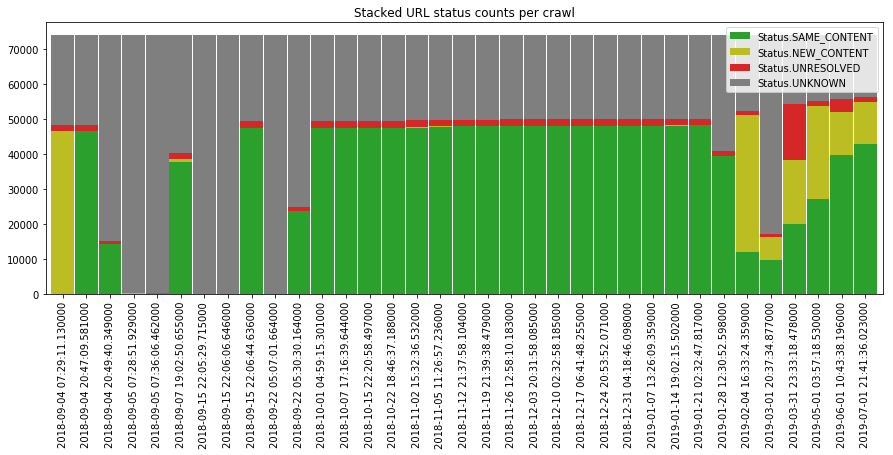

In [24]:
status_counts_df.plot(kind="bar", stacked=True, width=.96, color=status_color_map, figsize=(15, 5),
                      title="Stacked URL status counts per crawl");

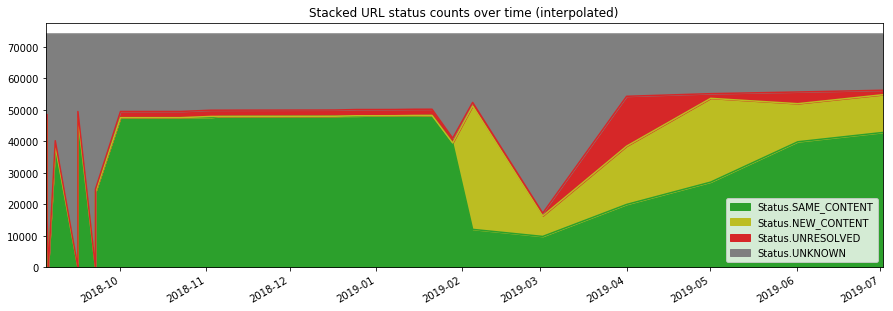

In [25]:
status_counts_df.plot(kind="area", stacked=True, color=status_color_map, figsize=(15, 5),
                      title="Stacked URL status counts over time (interpolated)");

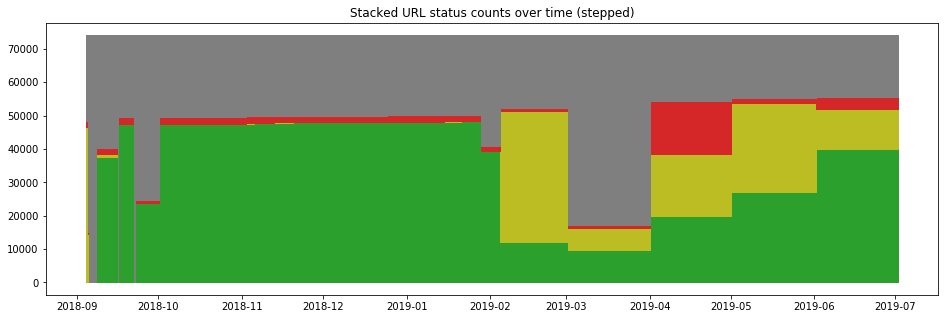

In [26]:
fig_df = status_counts_df

# Make figure
fig = plt.figure(figsize=(16, 5))
ax = fig.add_subplot(111, title="Stacked URL status counts over time (stepped)")

# Fill in space between lines
x = fig_df.index.append(pd.Index([datetime.datetime.now()]))
y1 = pd.Series({ q : 0 for q in x })

columns = status_counts_df.columns
n = len(columns)
for i in range(0, n):
    y2 = y1 + fig_df[columns[i]] + 0
    ax.fill_between(x, y1, y2, step="post", color=status_color_map[i])
    y1 = y2

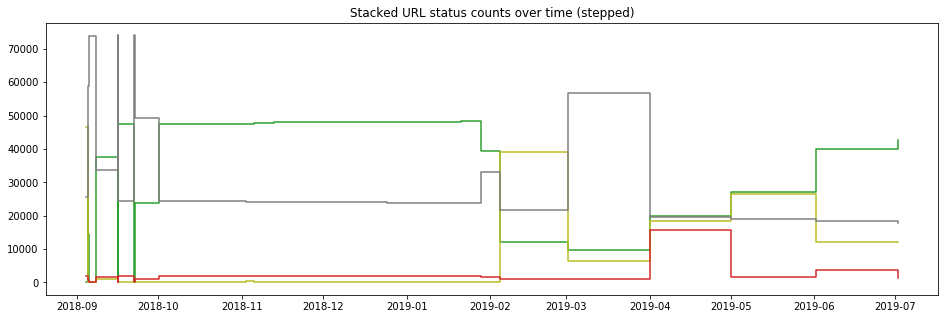

In [27]:
fig_df = status_counts_df

# Make figure
fig = plt.figure(figsize=(16, 5))
ax = fig.add_subplot(111, title="Stacked URL status counts over time (stepped)")

# Draw stepped lines
x = fig_df.index
for status in fig_df.columns:
    y = fig_df[status]
    plt.step(x, y, where="post", color=status_color[status.name])

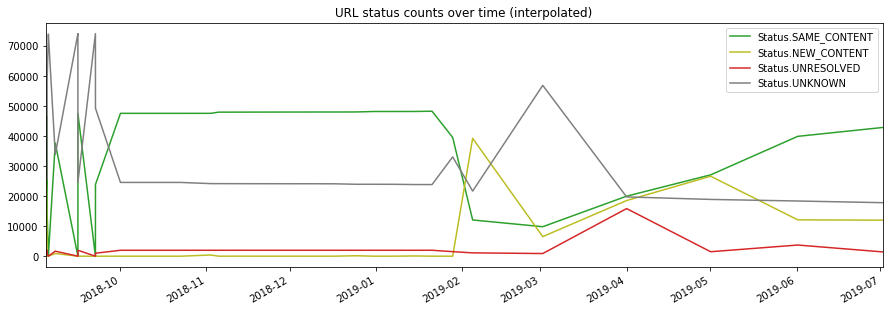

In [28]:
ax = fig_df.plot(kind="line", stacked=False, color=status_color_map, figsize=(15, 5),
                 title="URL status counts over time (interpolated)")

In [29]:
[x for x in enumerate(history_urls) if history_urls[x[0]] == "http://plazi.cs.umb.edu/GgServer/dwca/0014FFE9FF94FFA3126AFFF0FFA2D93F.zip"]

[(19206,
  'http://plazi.cs.umb.edu/GgServer/dwca/0014FFE9FF94FFA3126AFFF0FFA2D93F.zip')]

In [30]:
url_status_histories[19206]

[<Status.NEW_CONTENT: 2>,
 <Status.SAME_CONTENT: 3>,
 <Status.UNKNOWN: 1>,
 <Status.UNKNOWN: 1>,
 <Status.UNKNOWN: 1>,
 <Status.SAME_CONTENT: 3>,
 <Status.UNKNOWN: 1>,
 <Status.UNKNOWN: 1>,
 <Status.SAME_CONTENT: 3>,
 <Status.UNKNOWN: 1>,
 <Status.UNKNOWN: 1>,
 <Status.SAME_CONTENT: 3>,
 <Status.SAME_CONTENT: 3>,
 <Status.SAME_CONTENT: 3>,
 <Status.SAME_CONTENT: 3>,
 <Status.SAME_CONTENT: 3>,
 <Status.SAME_CONTENT: 3>,
 <Status.SAME_CONTENT: 3>,
 <Status.SAME_CONTENT: 3>,
 <Status.SAME_CONTENT: 3>,
 <Status.SAME_CONTENT: 3>,
 <Status.SAME_CONTENT: 3>,
 <Status.SAME_CONTENT: 3>,
 <Status.SAME_CONTENT: 3>,
 <Status.SAME_CONTENT: 3>,
 <Status.SAME_CONTENT: 3>,
 <Status.SAME_CONTENT: 3>,
 <Status.SAME_CONTENT: 3>,
 <Status.SAME_CONTENT: 3>,
 <Status.NEW_CONTENT: 2>,
 <Status.UNKNOWN: 1>,
 <Status.UNRESOLVED: 4>,
 <Status.UNKNOWN: 1>,
 <Status.UNKNOWN: 1>,
 <Status.UNKNOWN: 1>]